# Giesekus Flow Curve: Shear-Thinning and the Mobility Parameter

## Learning Objectives

1. Fit the Giesekus model to real emulsion flow curve data
2. Understand the mobility parameter α and its effect on shear-thinning
3. Compute the critical Weissenberg number Wi_c ≈ 1/√α
4. Use NLSQ warm-start for efficient Bayesian inference with NUTS
5. Compare single-mode vs multi-mode Giesekus fitting

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode, GiesekusMultiMode

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Giesekus Constitutive Model

The Giesekus model (1982) extends the Upper-Convected Maxwell (UCM) model by adding a **quadratic stress term** that accounts for anisotropic molecular interactions:

### Constitutive Equation

$$
\boldsymbol{\tau} + \lambda \stackrel{\nabla}{\boldsymbol{\tau}} + \frac{\alpha \lambda}{\eta_p} \boldsymbol{\tau} \cdot \boldsymbol{\tau} = 2\eta_p \mathbf{D}
$$

where:
- $\boldsymbol{\tau}$ = extra stress tensor (Pa)
- $\lambda$ = relaxation time (s)
- $\eta_p$ = polymer viscosity (Pa·s)
- $\alpha$ = mobility parameter (dimensionless, 0 ≤ α ≤ 0.5)
- $\stackrel{\nabla}{\boldsymbol{\tau}}$ = upper-convected derivative
- $\mathbf{D}$ = rate of deformation tensor

### Steady Shear Flow

For steady simple shear at rate $\dot{\gamma}$, the Giesekus model predicts:

**Shear stress:** $\sigma = \eta(\dot{\gamma}) \cdot \dot{\gamma}$

**Shear-thinning viscosity:**
$$
\eta(\dot{\gamma}) = \eta_s + \eta_p \frac{(1-f)^2}{1 + (1-2\alpha)f}
$$

where $f = f(\text{Wi}, \alpha)$ is a function of the Weissenberg number Wi = λγ̇.

### Key Physics

| Feature | Effect of α |
|---------|-------------|
| **Shear-thinning onset** | Wi_c ≈ 1/√α (earlier onset for larger α) |
| **High-shear slope** | Power-law exponent → -0.5 as Wi → ∞ |
| **Normal stresses** | N₂/N₁ = -α/2 (negative N₂ for α > 0) |
| **UCM limit** | α → 0: constant viscosity, N₂ = 0 |

### Parameters

| Parameter | Symbol | Units | Typical Range | Physical Meaning |
|-----------|--------|-------|---------------|------------------|
| `eta_p` | η_p | Pa·s | 0.1–10⁴ | Polymer viscosity contribution |
| `lambda_1` | λ | s | 10⁻³–10² | Relaxation time |
| `alpha` | α | — | 0–0.5 | Mobility/anisotropy parameter |
| `eta_s` | η_s | Pa·s | 0–10³ | Solvent viscosity |

**Zero-shear viscosity:** η₀ = η_p + η_s

## 3. Load Data

We use emulsion flow curve data at volume fraction φ = 0.80. This concentrated emulsion exhibits clear shear-thinning behavior suitable for Giesekus fitting.

In [3]:
# Load emulsion flow curve data
data_path = os.path.join("..", "data", "flow", "emulsions", "0.80.csv")
raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
gamma_dot = raw[:, 0]
stress = raw[:, 1]

print(f"Loaded {len(gamma_dot)} data points")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.1f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Loaded 30 data points
Shear rate range: [0.0016, 978.9] 1/s
Stress range: [23.69, 295.42] Pa


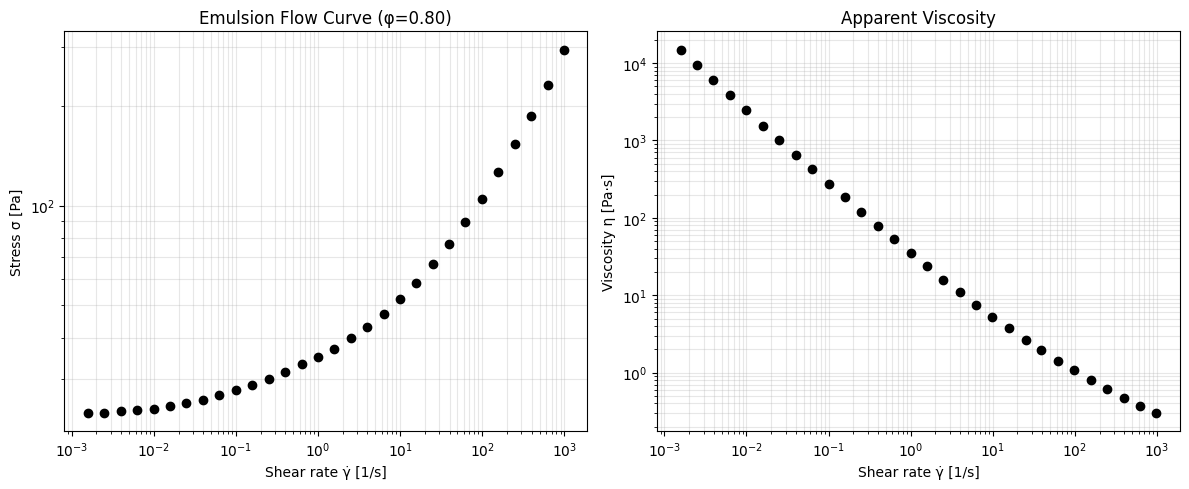

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Stress vs shear rate
ax1.loglog(gamma_dot, stress, "ko", markersize=6)
ax1.set_xlabel("Shear rate γ̇ [1/s]")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title("Emulsion Flow Curve (φ=0.80)")
ax1.grid(True, alpha=0.3, which="both")

# Viscosity vs shear rate
eta = stress / gamma_dot
ax2.loglog(gamma_dot, eta, "ko", markersize=6)
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("Viscosity η [Pa·s]")
ax2.set_title("Apparent Viscosity")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

We first fit the Giesekus model using nonlinear least squares (NLSQ) to obtain point estimates. These will serve as warm-start values for Bayesian inference.

In [5]:
# Create and fit Giesekus model
model = GiesekusSingleMode()

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

# Derived quantities
eta_p = model.parameters.get_value("eta_p")
eta_s = model.parameters.get_value("eta_s")
lambda_1 = model.parameters.get_value("lambda_1")
alpha = model.parameters.get_value("alpha")

eta_0 = eta_p + eta_s
if alpha > 0:
    Wi_c = 1.0 / np.sqrt(alpha)
    gamma_dot_c = Wi_c / lambda_1
    print(f"\nDerived quantities:")
    print(f"  η₀ = η_p + η_s = {eta_0:.2f} Pa·s")
    print(f"  Wi_c = 1/√α = {Wi_c:.2f}")
    print(f"  γ̇_c = Wi_c/λ = {gamma_dot_c:.2g} 1/s")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.594693s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=66 | final_cost=0.6141 | elapsed=1.595s | final_gradient_norm=9.4280e-05


NLSQ fit time: 2.18 s

Fitted parameters:
  eta_p      = 2.482e+04
  lambda_1   = 1e+04
  alpha      = 0.004854
  eta_s      = 0.3728

Derived quantities:
  η₀ = η_p + η_s = 24816.52 Pa·s
  Wi_c = 1/√α = 14.35
  γ̇_c = Wi_c/λ = 0.0014 1/s


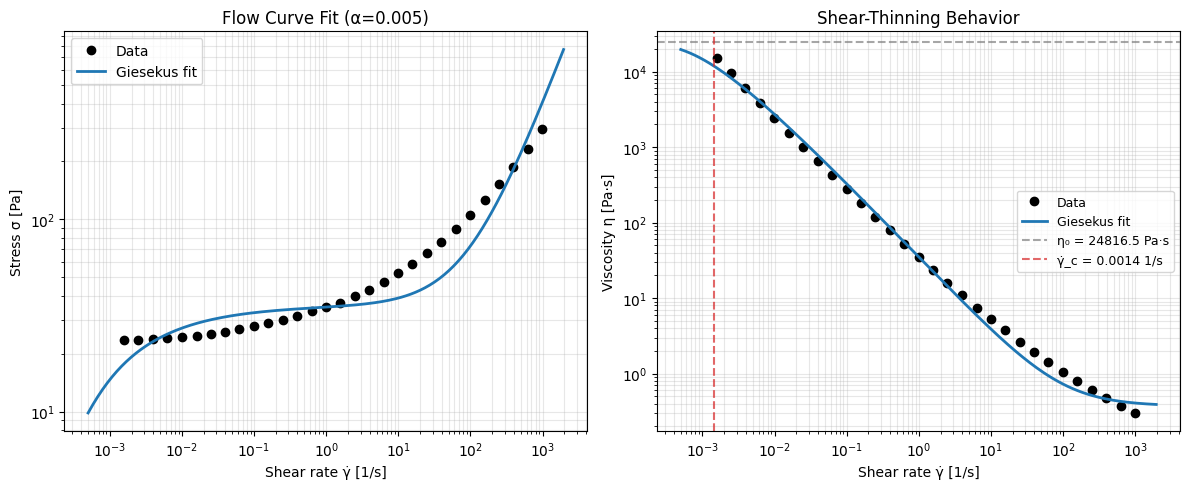

In [6]:
# Plot fit with data
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pred = model.predict(gamma_dot_fine, test_mode="flow_curve")
eta_pred = np.array(stress_pred) / gamma_dot_fine

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Stress
ax1.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax1.loglog(gamma_dot_fine, stress_pred, "-", lw=2, color="C0", label="Giesekus fit")
ax1.set_xlabel("Shear rate γ̇ [1/s]")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title(f"Flow Curve Fit (α={alpha:.3f})")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Viscosity
ax2.loglog(gamma_dot, eta, "ko", markersize=6, label="Data")
ax2.loglog(gamma_dot_fine, eta_pred, "-", lw=2, color="C0", label="Giesekus fit")
ax2.axhline(eta_0, color="gray", linestyle="--", alpha=0.7, label=f"η₀ = {eta_0:.1f} Pa·s")
if alpha > 0:
    ax2.axvline(gamma_dot_c, color="C3", linestyle="--", alpha=0.7, 
                label=f"γ̇_c = {gamma_dot_c:.2g} 1/s")
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("Viscosity η [Pa·s]")
ax2.set_title("Shear-Thinning Behavior")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling with the No-U-Turn Sampler (NUTS).

In [7]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  eta_p: 2.482e+04
  lambda_1: 1e+04
  alpha: 0.004854
  eta_s: 0.3728


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<04:38,  2.51it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 8/700 [00:00<00:35, 19.41it/s, 511 steps of size 4.36e-05. acc. prob=0.50]

warmup:   2%|▏         | 12/700 [00:00<00:30, 22.48it/s, 511 steps of size 4.78e-05. acc. prob=0.67]

warmup:   2%|▏         | 16/700 [00:01<00:42, 16.07it/s, 1023 steps of size 6.45e-05. acc. prob=0.75]

warmup:   3%|▎         | 19/700 [00:01<00:50, 13.53it/s, 1023 steps of size 9.06e-05. acc. prob=0.79]

warmup:   3%|▎         | 21/700 [00:01<00:53, 12.67it/s, 1023 steps of size 1.16e-04. acc. prob=0.81]

warmup:   3%|▎         | 23/700 [00:01<00:57, 11.82it/s, 1023 steps of size 1.48e-04. acc. prob=0.82]

warmup:   4%|▎         | 25/700 [00:01<01:00, 11.23it/s, 1023 steps of size 1.78e-04. acc. prob=0.84]

warmup:   4%|▍         | 27/700 [00:02<01:00, 11.05it/s, 1023 steps of size 2.19e-04. acc. prob=0.85]

warmup:   4%|▍         | 29/700 [00:02<01:01, 10.93it/s, 1023 steps of size 2.62e-04. acc. prob=0.86]

warmup:   4%|▍         | 31/700 [00:02<01:03, 10.52it/s, 1023 steps of size 3.29e-04. acc. prob=0.87]

warmup:   5%|▍         | 33/700 [00:02<01:05, 10.20it/s, 1023 steps of size 4.05e-04. acc. prob=0.88]

warmup:   5%|▌         | 35/700 [00:02<01:03, 10.53it/s, 511 steps of size 5.01e-04. acc. prob=0.88] 

warmup:   5%|▌         | 37/700 [00:03<01:00, 11.04it/s, 831 steps of size 6.15e-04. acc. prob=0.89]

warmup:   6%|▌         | 39/700 [00:03<00:59, 11.14it/s, 895 steps of size 7.50e-04. acc. prob=0.89]

warmup:   6%|▌         | 41/700 [00:03<00:54, 12.18it/s, 255 steps of size 9.08e-04. acc. prob=0.90]

warmup:   6%|▌         | 43/700 [00:03<00:51, 12.87it/s, 383 steps of size 1.09e-03. acc. prob=0.90]

warmup:   6%|▋         | 45/700 [00:03<00:52, 12.58it/s, 1023 steps of size 1.30e-03. acc. prob=0.91]

warmup:   7%|▋         | 49/700 [00:03<00:41, 15.62it/s, 1023 steps of size 1.81e-03. acc. prob=0.92]

warmup:   7%|▋         | 52/700 [00:03<00:36, 17.98it/s, 1023 steps of size 4.00e-04. acc. prob=0.91]

warmup:   8%|▊         | 54/700 [00:04<00:36, 17.82it/s, 1023 steps of size 4.77e-04. acc. prob=0.91]

warmup:   8%|▊         | 56/700 [00:04<00:42, 15.23it/s, 1023 steps of size 5.65e-04. acc. prob=0.91]

warmup:   8%|▊         | 58/700 [00:04<00:41, 15.31it/s, 1023 steps of size 6.66e-04. acc. prob=0.92]

warmup:   9%|▊         | 60/700 [00:04<00:43, 14.81it/s, 511 steps of size 7.81e-04. acc. prob=0.92] 

warmup:   9%|▉         | 62/700 [00:04<00:41, 15.24it/s, 255 steps of size 9.11e-04. acc. prob=0.92]

warmup:   9%|▉         | 64/700 [00:04<00:40, 15.63it/s, 31 steps of size 1.06e-03. acc. prob=0.92] 

warmup:   9%|▉         | 66/700 [00:04<00:42, 15.04it/s, 783 steps of size 1.22e-03. acc. prob=0.93]

warmup:  10%|▉         | 69/700 [00:05<00:38, 16.21it/s, 1023 steps of size 1.49e-03. acc. prob=0.93]

warmup:  10%|█         | 71/700 [00:05<00:46, 13.58it/s, 1023 steps of size 1.70e-03. acc. prob=0.93]

warmup:  10%|█         | 73/700 [00:05<00:46, 13.39it/s, 511 steps of size 1.93e-03. acc. prob=0.93] 

warmup:  11%|█         | 75/700 [00:05<00:51, 12.10it/s, 511 steps of size 2.19e-03. acc. prob=0.93]

warmup:  11%|█         | 78/700 [00:05<00:50, 12.20it/s, 1023 steps of size 2.64e-03. acc. prob=0.94]

warmup:  11%|█▏        | 80/700 [00:06<00:49, 12.58it/s, 319 steps of size 2.95e-03. acc. prob=0.94] 

warmup:  12%|█▏        | 83/700 [00:06<00:38, 15.87it/s, 511 steps of size 3.50e-03. acc. prob=0.94]

warmup:  12%|█▏        | 85/700 [00:06<00:42, 14.32it/s, 543 steps of size 3.90e-03. acc. prob=0.94]

warmup:  13%|█▎        | 88/700 [00:06<00:38, 16.08it/s, 975 steps of size 4.56e-03. acc. prob=0.94]

warmup:  13%|█▎        | 93/700 [00:06<00:29, 20.23it/s, 911 steps of size 5.88e-03. acc. prob=0.95]

warmup:  14%|█▎        | 96/700 [00:06<00:27, 21.89it/s, 671 steps of size 6.73e-03. acc. prob=0.95]

warmup:  14%|█▍        | 101/700 [00:06<00:21, 27.90it/s, 511 steps of size 8.03e-02. acc. prob=0.95]

warmup:  15%|█▌        | 105/700 [00:07<00:26, 22.15it/s, 1023 steps of size 4.59e-03. acc. prob=0.94]

warmup:  15%|█▌        | 108/700 [00:07<00:33, 17.65it/s, 511 steps of size 4.27e-03. acc. prob=0.95] 

warmup:  16%|█▌        | 111/700 [00:07<00:38, 15.12it/s, 1023 steps of size 4.62e-03. acc. prob=0.95]

warmup:  16%|█▌        | 113/700 [00:07<00:38, 15.24it/s, 831 steps of size 5.01e-03. acc. prob=0.95] 

warmup:  16%|█▋        | 115/700 [00:07<00:39, 14.92it/s, 639 steps of size 5.48e-03. acc. prob=0.95]

warmup:  17%|█▋        | 119/700 [00:08<00:31, 18.61it/s, 511 steps of size 6.68e-03. acc. prob=0.95]

warmup:  17%|█▋        | 122/700 [00:08<00:32, 17.63it/s, 255 steps of size 7.49e-03. acc. prob=0.95]

warmup:  18%|█▊        | 125/700 [00:08<00:29, 19.21it/s, 511 steps of size 8.59e-03. acc. prob=0.95]

warmup:  18%|█▊        | 128/700 [00:08<00:29, 19.72it/s, 479 steps of size 9.67e-03. acc. prob=0.95]

warmup:  19%|█▊        | 131/700 [00:08<00:27, 20.52it/s, 511 steps of size 1.08e-02. acc. prob=0.95]

warmup:  19%|█▉        | 136/700 [00:08<00:21, 25.81it/s, 271 steps of size 1.30e-02. acc. prob=0.96]

warmup:  20%|██        | 140/700 [00:08<00:20, 26.76it/s, 255 steps of size 1.50e-02. acc. prob=0.96]

warmup:  21%|██        | 144/700 [00:09<00:19, 28.28it/s, 255 steps of size 1.68e-02. acc. prob=0.96]

warmup:  21%|██▏       | 149/700 [00:09<00:16, 33.05it/s, 39 steps of size 1.70e-02. acc. prob=0.96] 

warmup:  22%|██▏       | 155/700 [00:09<00:14, 37.04it/s, 255 steps of size 1.16e-02. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [00:09<00:15, 34.67it/s, 255 steps of size 1.11e-02. acc. prob=0.96]

warmup:  23%|██▎       | 163/700 [00:09<00:16, 33.37it/s, 255 steps of size 1.20e-02. acc. prob=0.96]

warmup:  24%|██▍       | 167/700 [00:09<00:16, 32.53it/s, 127 steps of size 1.41e-02. acc. prob=0.96]

warmup:  24%|██▍       | 171/700 [00:09<00:15, 33.31it/s, 255 steps of size 1.52e-02. acc. prob=0.96]

warmup:  25%|██▌       | 175/700 [00:09<00:15, 32.96it/s, 255 steps of size 1.38e-02. acc. prob=0.96]

warmup:  26%|██▌       | 179/700 [00:10<00:15, 33.25it/s, 255 steps of size 1.63e-02. acc. prob=0.96]

warmup:  26%|██▌       | 183/700 [00:10<00:15, 33.33it/s, 255 steps of size 1.52e-02. acc. prob=0.96]

warmup:  27%|██▋       | 187/700 [00:10<00:15, 32.27it/s, 127 steps of size 1.66e-02. acc. prob=0.96]

warmup:  27%|██▋       | 192/700 [00:10<00:14, 35.29it/s, 255 steps of size 1.82e-02. acc. prob=0.96]

warmup:  28%|██▊       | 197/700 [00:10<00:13, 37.34it/s, 255 steps of size 1.90e-02. acc. prob=0.96]

sample:  29%|██▊       | 201/700 [00:10<00:13, 35.92it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  29%|██▉       | 206/700 [00:10<00:13, 36.72it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  30%|███       | 210/700 [00:10<00:13, 35.74it/s, 383 steps of size 1.67e-02. acc. prob=1.00]

sample:  31%|███       | 215/700 [00:11<00:12, 38.25it/s, 159 steps of size 1.67e-02. acc. prob=1.00]

sample:  31%|███▏      | 220/700 [00:11<00:11, 40.76it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [00:11<00:12, 39.33it/s, 63 steps of size 1.67e-02. acc. prob=0.99] 

sample:  33%|███▎      | 230/700 [00:11<00:11, 40.28it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  34%|███▎      | 235/700 [00:11<00:11, 40.63it/s, 95 steps of size 1.67e-02. acc. prob=0.99] 

sample:  34%|███▍      | 240/700 [00:11<00:11, 40.95it/s, 79 steps of size 1.67e-02. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [00:11<00:10, 42.18it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [00:11<00:10, 43.31it/s, 127 steps of size 1.67e-02. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [00:11<00:10, 42.53it/s, 63 steps of size 1.67e-02. acc. prob=0.99] 

sample:  37%|███▋      | 260/700 [00:12<00:11, 38.29it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [00:12<00:11, 38.88it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  38%|███▊      | 269/700 [00:12<00:11, 36.12it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [00:12<00:12, 35.42it/s, 383 steps of size 1.67e-02. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [00:12<00:12, 34.22it/s, 87 steps of size 1.67e-02. acc. prob=0.99] 

sample:  40%|████      | 282/700 [00:12<00:11, 37.74it/s, 135 steps of size 1.67e-02. acc. prob=0.99]

sample:  41%|████      | 287/700 [00:12<00:10, 39.50it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [00:12<00:10, 40.18it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  42%|████▏     | 297/700 [00:13<00:10, 40.08it/s, 47 steps of size 1.67e-02. acc. prob=0.99] 

sample:  43%|████▎     | 303/700 [00:13<00:09, 42.62it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  44%|████▍     | 308/700 [00:13<00:09, 40.23it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [00:13<00:09, 39.07it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [00:13<00:09, 39.80it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [00:13<00:09, 37.74it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [00:13<00:10, 37.21it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  47%|████▋     | 331/700 [00:13<00:09, 37.69it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  48%|████▊     | 337/700 [00:14<00:08, 43.24it/s, 31 steps of size 1.67e-02. acc. prob=0.99] 

sample:  49%|████▉     | 343/700 [00:14<00:07, 45.92it/s, 111 steps of size 1.67e-02. acc. prob=0.99]

sample:  50%|████▉     | 349/700 [00:14<00:07, 47.90it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  51%|█████     | 354/700 [00:14<00:07, 44.25it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [00:14<00:07, 43.35it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  52%|█████▏    | 364/700 [00:14<00:08, 39.16it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [00:14<00:07, 41.51it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [00:14<00:07, 41.47it/s, 151 steps of size 1.67e-02. acc. prob=0.99]

sample:  54%|█████▍    | 380/700 [00:15<00:07, 41.12it/s, 127 steps of size 1.67e-02. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [00:15<00:07, 39.73it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [00:15<00:08, 38.71it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  56%|█████▋    | 395/700 [00:15<00:07, 40.21it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [00:15<00:06, 42.83it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  58%|█████▊    | 406/700 [00:15<00:07, 39.96it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  59%|█████▉    | 412/700 [00:15<00:06, 42.03it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  60%|█████▉    | 417/700 [00:15<00:06, 42.53it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  60%|██████    | 422/700 [00:16<00:06, 43.20it/s, 119 steps of size 1.67e-02. acc. prob=0.99]

sample:  61%|██████    | 428/700 [00:16<00:05, 45.46it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  62%|██████▏   | 433/700 [00:16<00:06, 40.82it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [00:16<00:06, 39.51it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [00:16<00:06, 38.72it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  64%|██████▍   | 447/700 [00:16<00:06, 38.46it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:16<00:06, 38.48it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [00:16<00:06, 38.77it/s, 127 steps of size 1.67e-02. acc. prob=0.99]

sample:  66%|██████▌   | 461/700 [00:17<00:05, 40.24it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  67%|██████▋   | 466/700 [00:17<00:06, 37.44it/s, 383 steps of size 1.67e-02. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [00:17<00:05, 39.34it/s, 127 steps of size 1.67e-02. acc. prob=0.99]

sample:  68%|██████▊   | 475/700 [00:17<00:06, 35.10it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  68%|██████▊   | 479/700 [00:17<00:06, 32.98it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  69%|██████▉   | 484/700 [00:17<00:06, 34.92it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  70%|███████   | 490/700 [00:17<00:05, 40.73it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  71%|███████   | 495/700 [00:17<00:04, 42.26it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  71%|███████▏  | 500/700 [00:18<00:04, 40.52it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  72%|███████▏  | 506/700 [00:18<00:04, 44.36it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [00:18<00:04, 43.97it/s, 191 steps of size 1.67e-02. acc. prob=0.99]

sample:  74%|███████▎  | 516/700 [00:18<00:04, 40.42it/s, 511 steps of size 1.67e-02. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [00:18<00:04, 44.48it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  75%|███████▌  | 527/700 [00:18<00:03, 43.73it/s, 103 steps of size 1.67e-02. acc. prob=0.99]

sample:  76%|███████▌  | 532/700 [00:18<00:04, 39.14it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [00:19<00:04, 38.85it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [00:19<00:03, 40.17it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [00:19<00:03, 41.73it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [00:19<00:03, 39.06it/s, 159 steps of size 1.67e-02. acc. prob=0.99]

sample:  80%|███████▉  | 557/700 [00:19<00:03, 41.22it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  81%|████████  | 564/700 [00:19<00:02, 48.12it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  81%|████████▏ | 569/700 [00:19<00:02, 44.25it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  82%|████████▏ | 574/700 [00:19<00:02, 42.08it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  83%|████████▎ | 579/700 [00:19<00:02, 42.57it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  84%|████████▎ | 585/700 [00:20<00:02, 46.99it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  84%|████████▍ | 591/700 [00:20<00:02, 47.84it/s, 127 steps of size 1.67e-02. acc. prob=0.98]

sample:  85%|████████▌ | 596/700 [00:20<00:02, 45.36it/s, 127 steps of size 1.67e-02. acc. prob=0.98]

sample:  86%|████████▌ | 601/700 [00:20<00:02, 44.58it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  87%|████████▋ | 606/700 [00:20<00:02, 42.34it/s, 127 steps of size 1.67e-02. acc. prob=0.98]

sample:  87%|████████▋ | 611/700 [00:20<00:02, 43.82it/s, 127 steps of size 1.67e-02. acc. prob=0.98]

sample:  88%|████████▊ | 616/700 [00:20<00:01, 45.42it/s, 7 steps of size 1.67e-02. acc. prob=0.98]  

sample:  89%|████████▊ | 621/700 [00:20<00:01, 42.24it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  89%|████████▉ | 626/700 [00:21<00:01, 39.81it/s, 255 steps of size 1.67e-02. acc. prob=0.98]

sample:  90%|█████████ | 631/700 [00:21<00:01, 40.64it/s, 63 steps of size 1.67e-02. acc. prob=0.99] 

sample:  91%|█████████ | 636/700 [00:21<00:01, 42.45it/s, 191 steps of size 1.67e-02. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [00:21<00:01, 40.11it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [00:21<00:01, 43.44it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [00:21<00:01, 41.97it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [00:21<00:01, 39.00it/s, 79 steps of size 1.67e-02. acc. prob=0.99] 

sample:  95%|█████████▍| 663/700 [00:21<00:00, 41.82it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [00:22<00:00, 42.05it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [00:22<00:00, 42.44it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [00:22<00:00, 41.21it/s, 15 steps of size 1.67e-02. acc. prob=0.99] 

sample:  98%|█████████▊| 683/700 [00:22<00:00, 40.24it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [00:22<00:00, 42.49it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [00:22<00:00, 39.29it/s, 255 steps of size 1.67e-02. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [00:22<00:00, 37.60it/s, 207 steps of size 1.67e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:22<00:00, 30.59it/s, 255 steps of size 1.67e-02. acc. prob=0.99]


Bayesian inference time: 26.6 s


## 6. Convergence Diagnostics

Check R-hat (target < 1.01) and effective sample size (ESS, target > 400 per chain).

In [8]:
# Convergence diagnostics table
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

all_pass = True
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    r_hat_ok = r_hat < 1.05
    ess_ok = ess > 100
    status = "PASS" if (r_hat_ok and ess_ok) else "CHECK"
    if status == "CHECK":
        all_pass = False
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")
if all_pass and n_div == 0:
    print("\nAll convergence criteria PASSED")
else:
    print("\nCHECK REQUIRED: Increase num_warmup/num_samples")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p    1.0000       500      PASS
    lambda_1    1.0000       500      PASS
       alpha    1.0000       500      PASS
       eta_s    1.0000       500      PASS

Divergences: 4

CHECK REQUIRED: Increase num_warmup/num_samples


## 7. ArviZ Diagnostic Plots

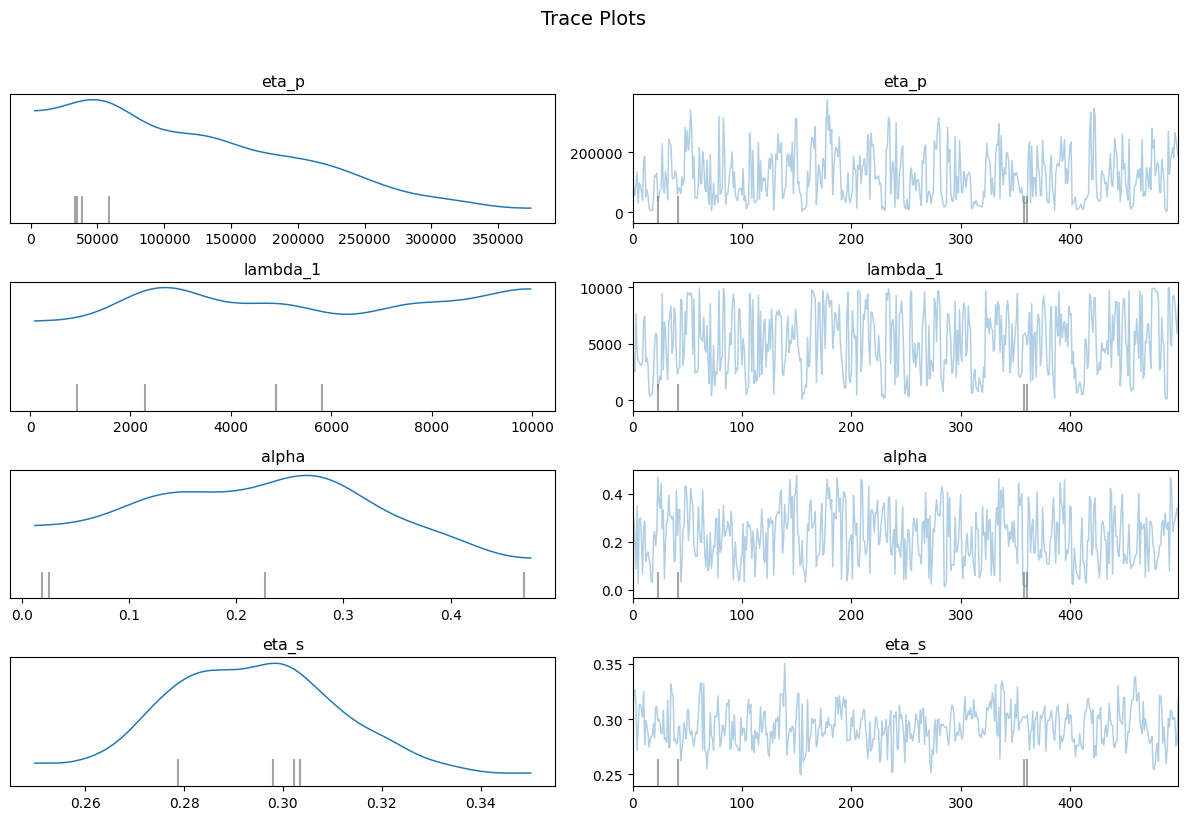

In [9]:
# Trace plots
idata = result.to_inference_data()

axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

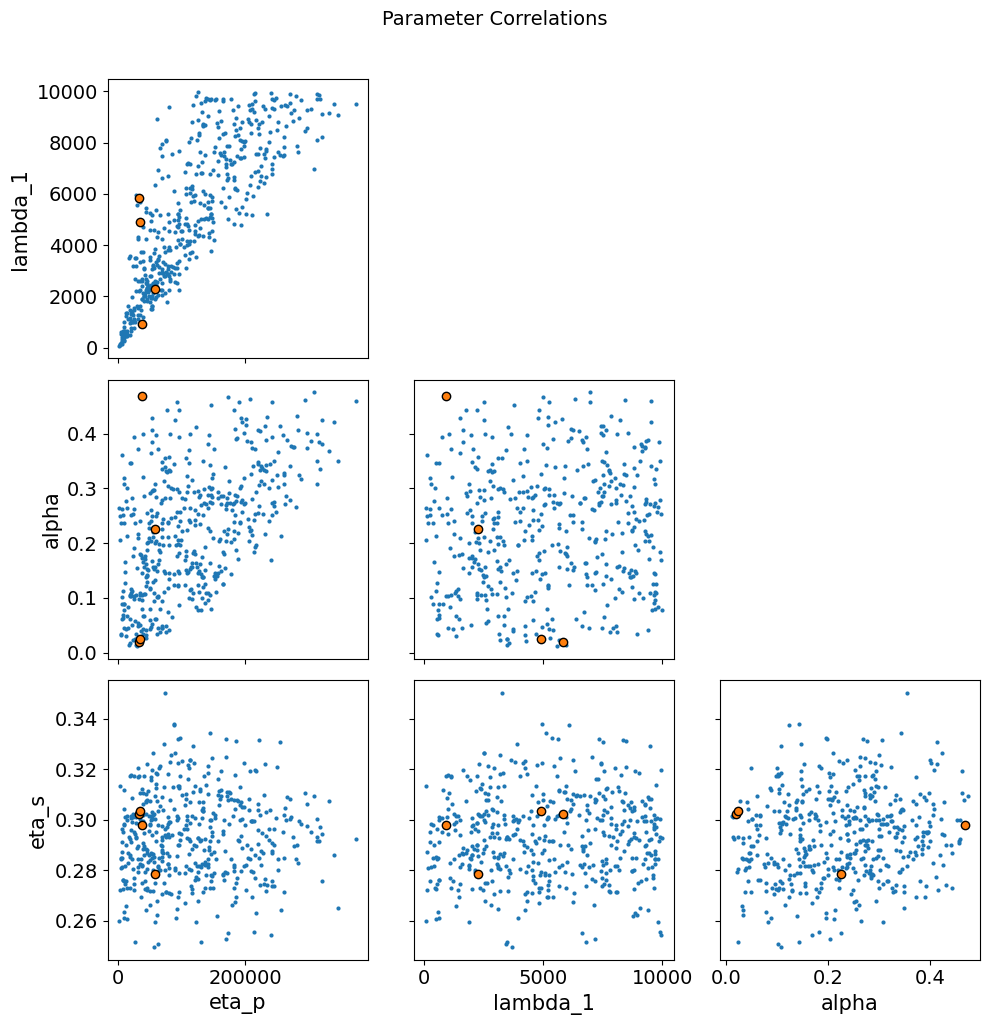

In [10]:
# Pair plot with divergences
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

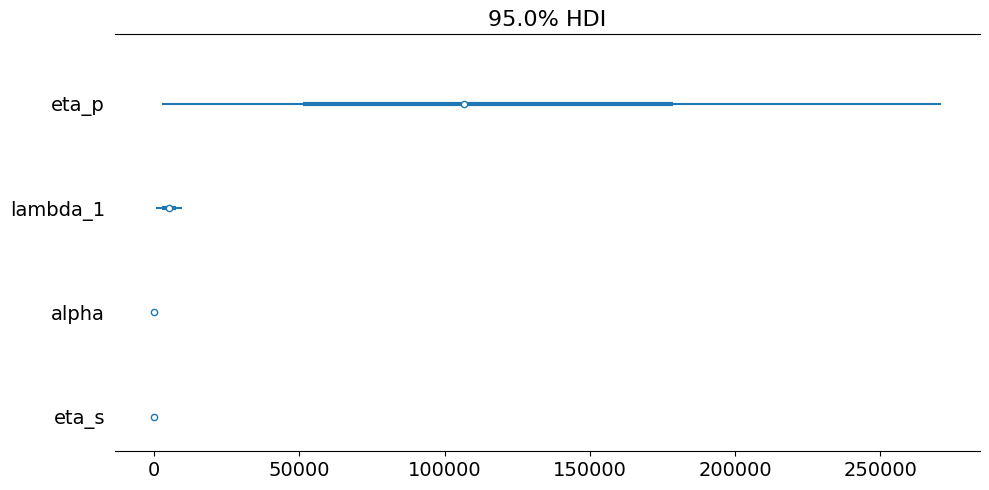

In [11]:
# Forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 5),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Posterior Predictive Check

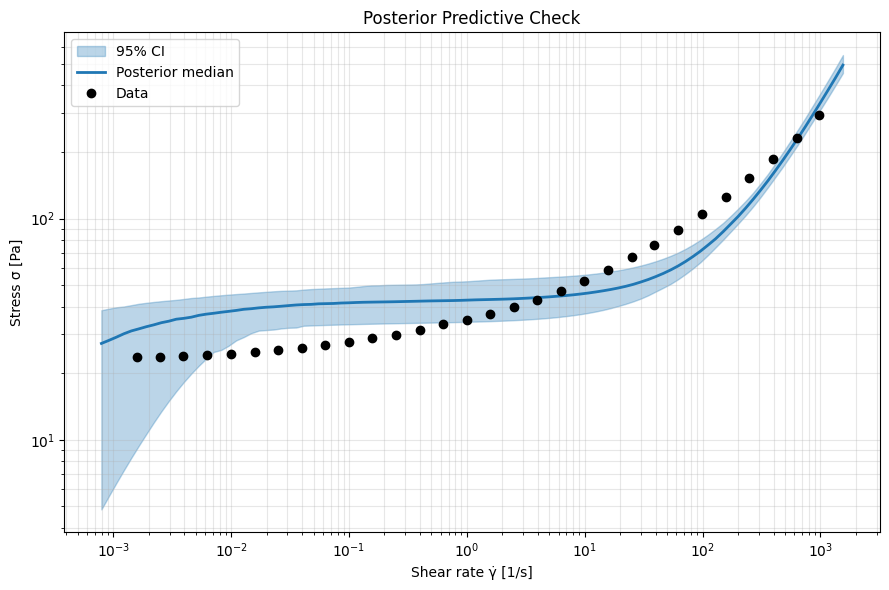

In [12]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples
n_draws = min(200, len(posterior["alpha"]))

gamma_dot_pred = np.logspace(
    np.log10(gamma_dot.min()) - 0.3,
    np.log10(gamma_dot.max()) + 0.2,
    100,
)

pred_samples = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    
    # Predict using the correct API
    pred_i = model.predict(gamma_dot_pred, test_mode="flow_curve")
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax.set_xlabel("Shear rate γ̇ [1/s]")
ax.set_ylabel("Stress σ [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 9. Parameter Summary

In [13]:
# NLSQ vs Bayesian comparison table
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 70)
print(f"{'Param':>12s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>26s}")
print("-" * 70)

for name in param_names:
    nlsq_val = model.parameters.get_value(name)
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>12s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

# Derived quantities from posterior
alpha_samples = np.array(posterior["alpha"])
print(f"\nPosterior α statistics:")
print(f"  Mean: {np.mean(alpha_samples):.4f}")
print(f"  Std:  {np.std(alpha_samples):.4f}")
print(f"  N₂/N₁ = -α/2 = [{-np.percentile(alpha_samples, 97.5)/2:.4f}, {-np.percentile(alpha_samples, 2.5)/2:.4f}]")

Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ    Bayes median                      95% CI
----------------------------------------------------------------------
       eta_p     3.168e+04       1.067e+05  [8381, 3.012e+05]
    lambda_1          1534            5017  [445, 9709]
       alpha        0.2093          0.2285  [0.03154, 0.4374]
       eta_s        0.2815          0.2933  [0.2612, 0.3264]

Posterior α statistics:
  Mean: 0.2253
  Std:  0.1130
  N₂/N₁ = -α/2 = [-0.2187, -0.0158]


## 10. Multi-Mode Comparison (Optional)

For broad relaxation spectra, multi-mode Giesekus may provide better fits. Let's briefly compare single-mode vs 3-mode fitting.

In [14]:
# Helper function to compute fit quality metrics
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# Multi-mode Giesekus (3 modes)
model_multi = GiesekusMultiMode(n_modes=3)

t0 = time.time()
model_multi.fit(gamma_dot, stress, test_mode="flow_curve")
t_multi = time.time() - t0

# Compute fit quality for both models
stress_single_pred = model.predict(gamma_dot, test_mode="flow_curve")
stress_multi_pred = model_multi.predict(gamma_dot, test_mode="flow_curve")

metrics_single = compute_fit_quality(stress, stress_single_pred)
metrics_multi = compute_fit_quality(stress, stress_multi_pred)

print(f"Multi-mode NLSQ fit time: {t_multi:.2f} s")
print(f"\nSingle-mode R²: {metrics_single['R2']:.6f}")
print(f"Multi-mode R²:  {metrics_multi['R2']:.6f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=10 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.053677s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=34 | final_cost=2.1813 | elapsed=2.054s | final_gradient_norm=101.3562


Multi-mode NLSQ fit time: 2.75 s

Single-mode R²: 0.923800
Multi-mode R²:  0.924261


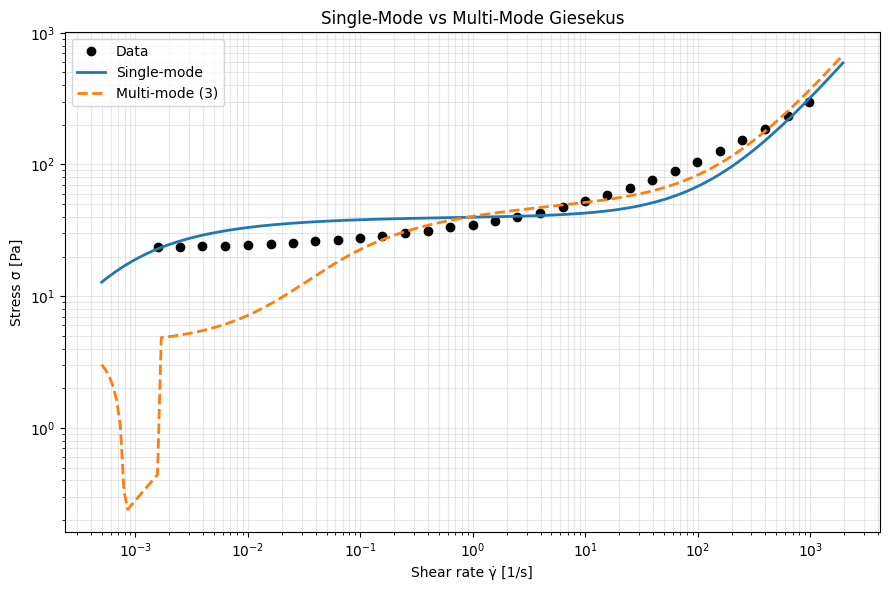

In [15]:
# Compare fits
stress_single = model.predict(gamma_dot_fine, test_mode="flow_curve")
stress_multi = model_multi.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax.loglog(gamma_dot_fine, stress_single, "-", lw=2, color="C0", label="Single-mode")
ax.loglog(gamma_dot_fine, stress_multi, "--", lw=2, color="C1", label="Multi-mode (3)")
ax.set_xlabel("Shear rate γ̇ [1/s]")
ax.set_ylabel("Stress σ [Pa]")
ax.set_title("Single-Mode vs Multi-Mode Giesekus")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 11. Save Results

Save parameters for use in downstream notebooks (startup, LAOS, normal stresses).

In [16]:
# Save results for downstream notebooks
output_dir = os.path.join("..", "outputs", "giesekus", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (used by NB 03, 04, 07)
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in param_names
}
with open(os.path.join(output_dir, "nlsq_params_flow_curve.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_flow_curve.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params_flow_curve.json: {len(nlsq_params)} parameters")
print(f"  posterior_flow_curve.json: {len(alpha_samples)} draws")
print(f"\nThese parameters will be used by:")
print(f"  - NB 03: Startup shear (synthetic data)")
print(f"  - NB 04: Normal stresses (synthetic data)")
print(f"  - NB 07: LAOS (synthetic data)")

Results saved to ../outputs/giesekus/flow_curve/
  nlsq_params_flow_curve.json: 4 parameters
  posterior_flow_curve.json: 500 draws

These parameters will be used by:
  - NB 03: Startup shear (synthetic data)
  - NB 04: Normal stresses (synthetic data)
  - NB 07: LAOS (synthetic data)


## Key Takeaways

1. **Giesekus captures shear-thinning** via the quadratic stress term τ·τ. The mobility parameter α controls the onset and magnitude of shear-thinning.

2. **Critical Weissenberg number** Wi_c ≈ 1/√α marks the onset of significant shear-thinning. Larger α means earlier onset.

3. **Normal stress prediction**: N₂/N₁ = -α/2 is a key diagnostic. This will be explored in NB 04.

4. **UCM limit**: As α → 0, Giesekus reduces to Upper-Convected Maxwell with constant viscosity and N₂ = 0.

5. **Multi-mode Giesekus** can capture broader relaxation spectra but may be overparameterized for simple flow curves.

### When to Use Giesekus vs Other Models

| Material | Recommended Model | Reason |
|----------|------------------|--------|
| Polymer melts/solutions | **Giesekus** | Shear-thinning + normal stresses |
| Dilute polymer solutions | **Oldroyd-B** | Small α (nearly UCM) |
| Concentrated emulsions | **Giesekus** | Strong shear-thinning |
| Yield-stress fluids | **HL/DMT** | Thixotropy, yield stress |
| Soft glasses | **SGR** | Trap dynamics |

### Next Steps

- **NB 02**: SAOS (α-independent in linear regime)
- **NB 03**: Startup shear (stress overshoot)
- **NB 04**: Normal stresses (N₂/N₁ = -α/2)
- **NB 05**: Creep
- **NB 06**: Stress relaxation
- **NB 07**: LAOS (nonlinear oscillatory response)